# Cook It Up with the Fantastic Four

In [79]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams

## Data Collection

In [34]:
full_df = pd.read_json("train.json")
full_df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [35]:
test_df = pd.read_json("test.json")
test_df.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


### Validation: Holdout Method

In a supervised learning problem one wants to determine how good the trained model is. Before the model is trained, the data is split into a training data set and a test data set. The training data set is used to train the model. The test data set is kept apart and used to determine how good the model is.

In [4]:
#This function returns a list of 100 id's for each cusine from input dataframe.
def build_df(indf):
    
    validdf_ids=[]
    random_ids=[]
    
    for k, v in indf.groupby('cuisine'):
        l=[]
        l.append([e for e in v.id])
        for i in xrange(len(l)):
            random_ids.append(np.random.choice(l[i], size=100, replace=False))
    
    validdf_ids = [item for sublist in random_ids for item in sublist]
    
    return validdf_ids

In [5]:
validation_df=full_df[full_df.id.isin(build_df(full_df))].reset_index()
train_df=full_df[~full_df.id.isin(build_df(full_df))].reset_index()

In [6]:
print "Full Dataframe"
print full_df.count()
print
print "Validation Dataframe"
print validation_df.count()
print
print "Training Dataframe"
print train_df.count()

Full Dataframe
cuisine        39774
id             39774
ingredients    39774
dtype: int64

Validation Dataframe
index          2000
cuisine        2000
id             2000
ingredients    2000
dtype: int64

Training Dataframe
index          37774
cuisine        37774
id             37774
ingredients    37774
dtype: int64


### Ingredients Map

In [7]:
#list of all possible ingredients

ingredients_all=[]

for i in full_df['ingredients']:
    for j in xrange(len(i)):
        ingredients_all.append(i[j])
        
for i in test_df['ingredients']:
    for j in xrange(len(i)):
        ingredients_all.append(i[j])

features=np.unique(ingredients_all) #create a feature list of unique ingrediants.

ingredients_map={v:k for k,v in enumerate(np.unique(ingredients_all).tolist())} #assign key to each ingredient

### Term-Document Matrix

In [8]:
def build_designmatrix(indf):
    
    designmatrix=np.zeros((len(indf), len(features))) 
    all_ids = indf['id'] #list of all id's from input set.
    
    #build design matrix
    for i in xrange(len(indf)):
        for j in indf['ingredients'][indf['id']==all_ids[i]]:
                for k in xrange(len(j)):
                        designmatrix[i, ingredients_map[j[k]]] = 1
                        
    return designmatrix

## Modeling & Optimization

### Decision Tree Classification Model

A decision tree aims at minimizing entropy. Entropy is a measure of chaos; something that is very ordered has a very low entropy, something that is very messy has a very high entropy. A decision tree is structure that resembles a flow chart. Every node in the tree represents a decision that needs to be taken for determining the class. Based on the training data the most relevant features and their values are selected for lowering the entropy of the data set. In contrast to many other approaches to classification, decision trees are easy to interpret by humans. Though decision trees are mainly used for classification, they can also be used for regression.

In [9]:
%%time
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(build_designmatrix(train_df), train_df['cuisine'])
clf_predict=clf.predict(build_designmatrix(validation_df))

CPU times: user 5min 19s, sys: 3.53 s, total: 5min 23s
Wall time: 5min 24s


In [10]:
from sklearn.metrics import accuracy_score
print "Accuracy score for DecisionTreeClassifier" 
print accuracy_score(np.array(validation_df['cuisine']),clf_predict)

Accuracy score for DecisionTreeClassifier
0.931


In [11]:
predictions_as_dataframe = test_df.join(pd.DataFrame({"Prediction DT": clf_predict}))
print predictions_as_dataframe

         id                                        ingredients Prediction DT
0     18009  [baking powder, eggs, all-purpose flour, raisi...          thai
1     28583  [sugar, egg yolks, corn starch, cream of tarta...  cajun_creole
2     41580  [sausage links, fennel bulb, fronds, olive oil...  cajun_creole
3     29752  [meat cuts, file powder, smoked sausage, okra,...      filipino
4     35687  [ground black pepper, salt, sausage casings, l...        indian
5     38527  [baking powder, all-purpose flour, peach slice...        korean
6     19666             [grape juice, orange, white zinfandel]        korean
7     41217  [ground ginger, white pepper, green onions, or...        korean
8     28753  [diced onions, taco seasoning mix, all-purpose...        korean
9     22659  [eggs, cherries, dates, dark muscovado sugar, ...    vietnamese
10    21749  [pasta, olive oil, crushed red pepper, cherry ...        korean
11    44967  [water, butter, ground sumac, ground lamb, gro...       italian

In [31]:
#Predict on test set and write the result out.
final_result=clf.predict(build_designmatrix(test_df))
test_df['cuisine']=final_result
test_df.to_csv("Decision Tree Submission.csv")

### Random Forest Classification Model

A random forest is a model ensemble. An ensemble combines multiple models to achieve better results than a single model would. A random forest consists of multiple decision trees. Each tree in the forest has a different random subset of the features (subspace sampling) and the trees are fed with different subsets of the training data (bagging). Though a random forest gives more accurate results than a single decision tree, it is harder to read and takes more computational time to generate.



In [13]:
from time import time

# Machine Learning
from sklearn.ensemble import RandomForestClassifier

# Helper
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
words = [' '.join(item) for item in full_df.ingredients]

In [16]:
vec = CountVectorizer(max_features=2000)  #Convert a collection of text documents to a matrix of token counts
bag_of_words = vec.fit(words).transform(words).toarray() #Transform documents to document-term matrix.
len(bag_of_words)

39774

In [17]:
random_forest = RandomForestClassifier(n_estimators=200) #creates a 200 tree forest

In [20]:
%%time
start = time()
random_forest.fit(bag_of_words, full_df.cuisine) #Learn a vocabulary dictionary of all tokens in the raw documents

CPU times: user 3min 12s, sys: 2.02 s, total: 3min 14s
Wall time: 3min 14s


In [22]:
%%time
start = time()
train_pred = cross_val_predict(random_forest, bag_of_words, full_df.cuisine, cv=2) #Generate cross-validated estimates for each input data point

CPU times: user 2min 38s, sys: 3.36 s, total: 2min 41s
Wall time: 2min 42s


In [23]:
len(train_pred)

39774

In [26]:
print("Accuracy: ", accuracy_score(full_df.cuisine, train_pred))

('Accuracy: ', 0.74108714235430184)


In [27]:
test = pd.read_json('test.json')

In [28]:
test_words = [' '.join(item) for item in test.ingredients]
test_bag = vec.transform(test_words).toarray()

In [29]:
len(test_bag)

9944

In [30]:
result = random_forest.predict(test_bag)

output = pd.DataFrame(data={"id":test.id, "ingredients":test.ingredients, "cuisine":result})
output.head(20)
output.to_csv("Random Forest Submission.csv")

### Ridge Regression Model

In [ ]:
%%time
from sklearn import preprocessing
from sklearn.linear_model import Ridge
est = Ridge(alpha=10)

labels = train_df['cuisine']
le = preprocessing.LabelEncoder()
labels_fea = le.fit_transform(labels)
est_fit=est.fit(build_designmatrix(train_df), labels_fea)
est_predict=est_fit.predict(build_designmatrix(test_df))
labels_converted = le.inverse_transform(est_predict.astype('I'))



In [ ]:
predictions_as_dataframe = test_df.join(pd.DataFrame({"Prediction R": labels_converted}))
print predictions_as_dataframe

### Naive Bayes Model

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

def conc_str(in_list):
    return ','.join(in_list)

def make_xy(indf, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(indf['ingredients'].apply(conc_str))
    X = X.tocsc()  # some versions of sklearn return COO format
    y = indf['cuisine']
    return X, y

X, y = make_xy(full_df)

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y)
clf = MultinomialNB().fit(xtrain, ytrain)
print "MN Accuracy: %0.2f%%" % (100 * clf.score(xtest, ytest))

MN Accuracy: 72.21%


In [38]:
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

Accuracy on training data: 0.75
Accuracy on test data:     0.72


In [39]:
from sklearn.cross_validation import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [40]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

In [46]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(full_df.shape[0]), train_size=0.7)
mask=np.ones(full_df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]

In [47]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy(full_df, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        #your code here
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

ValueError: Unknown label type: array([nan, u'mexican', u'korean', ..., nan, nan, u'british'], dtype=object)

### Ensemble Model

In [100]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# Generic classification and optimization functions from CS-109 labs
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
# clf - original classifier
# parameters - grid to search over
# X - usually your training X matrix
# y - usually your training y 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [101]:
%%time
from sklearn import tree
clfTree1 = tree.DecisionTreeClassifier()
#parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
#parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
parameters = {"max_depth": [None], 'min_samples_leaf': [4, 5, 6]}

clf = cv_optimize(clfTree1, parameters, Xtrain, ytrain, n_jobs=1, n_folds=5, score_func='f1_weighted')
clfDecisionTree=clf.fit(Xtrain, ytrain)
    
training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clf.predict(Xtest))
print "########################################################"

BEST {'max_depth': None, 'min_samples_leaf': 5} 0.615607738435 [mean: 0.61260, std: 0.00579, params: {'max_depth': None, 'min_samples_leaf': 4}, mean: 0.61561, std: 0.00564, params: {'max_depth': None, 'min_samples_leaf': 5}, mean: 0.61442, std: 0.00564, params: {'max_depth': None, 'min_samples_leaf': 6}]
############# based on standard predict ################
Accuracy on training data: 0.76
Accuracy on test data:     0.63
[[  53    2    7    1    2    8    1    3    1   16    1    0    0   10
     2    2   15    6    0    6]
 [   2   61    2    1    4   45    3    5   16   25    4    0    1    5
     2   12   35    1    0    0]
 [   4    9  262    6    3   37    1    9    3   39    8    2    0   28
     2    3   63    4    0    0]
 [   1    8    6  602   27    8    1    9    0   19    1   50   24   11
     0    4   23    1   19   12]
 [   8    5    5   41   72   10    2    3    1    8    5    6    6    7
     0    0   14    5    7    3]
 [   4   29   13   10    2  350   17    7   11 

In [102]:
%%time

from sklearn.ensemble import RandomForestClassifier
clfForest = RandomForestClassifier()
parameters = {"n_estimators": range(1, 20)}

clf = cv_optimize(clfForest, parameters, Xtrain, ytrain, n_jobs=1, n_folds=5, score_func='f1_weighted')
clfRandomForest=clf.fit(Xtrain, ytrain)

training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clf.predict(Xtest))
print "########################################################"

BEST {'n_estimators': 18} 0.699178649119 [mean: 0.50306, std: 0.00583, params: {'n_estimators': 1}, mean: 0.48943, std: 0.00360, params: {'n_estimators': 2}, mean: 0.56214, std: 0.01001, params: {'n_estimators': 3}, mean: 0.59921, std: 0.00565, params: {'n_estimators': 4}, mean: 0.63073, std: 0.00413, params: {'n_estimators': 5}, mean: 0.63879, std: 0.00834, params: {'n_estimators': 6}, mean: 0.65502, std: 0.00327, params: {'n_estimators': 7}, mean: 0.66301, std: 0.00541, params: {'n_estimators': 8}, mean: 0.66999, std: 0.00554, params: {'n_estimators': 9}, mean: 0.67215, std: 0.01010, params: {'n_estimators': 10}, mean: 0.68088, std: 0.00227, params: {'n_estimators': 11}, mean: 0.68418, std: 0.00309, params: {'n_estimators': 12}, mean: 0.68583, std: 0.00273, params: {'n_estimators': 13}, mean: 0.69006, std: 0.00422, params: {'n_estimators': 14}, mean: 0.68859, std: 0.00634, params: {'n_estimators': 15}, mean: 0.69847, std: 0.00677, params: {'n_estimators': 16}, mean: 0.69777, std: 0.0

In [103]:
%%time

from sklearn.ensemble import AdaBoostClassifier
clfAda = AdaBoostClassifier()
parameters = {"n_estimators": range(10, 60)}

clf = cv_optimize(clfAda, parameters, Xtrain, ytrain, n_jobs=1, n_folds=5, score_func='f1_weighted')
clfAdaBoost=clf.fit(Xtrain, ytrain)

training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print confusion_matrix(ytest, clf.predict(Xtest))
print "########################################################"

KeyboardInterrupt: 

## Visualization

### ROC Curves of Model Performances

In [70]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [ ]:
%%time

clfAda, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda, parameters, dftouse,lcols, u'RESP',1, mask=mask)

In [ ]:
with sns.color_palette("dark"):
    ax=make_roc("Random Forest",clfDecisionTree, ytest, Xtest, labe=200, skip=50)
    make_roc("Naive Bayes",clfNaiveBayes, ytest, Xtest, ax, labe=200, proba=False, skip=50);
    make_roc("Decision Tree",clfRandomForest, ytest, Xtest, ax, labe=200, proba=False, skip=50);
    make_roc("AdaBoost",clfAdaBoost, ytest, Xtest, ax, labe=200, proba=False, skip=50);

<img src="./images/Unknown.png">

### Horizontal Plots of Model Performances

<img src="./images/score_0.png">

### Visualizing Classifiers Using Decision Surfaces

In [9]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    
# your code here
imp_cols = clfForest.feature_importances_.argsort()[::-1][0:2]



CPU times: user 5min 19s, sys: 3.53 s, total: 5min 23s
Wall time: 5min 24s


In [ ]:
X_imp = df[imp_cols].values
Y = traindf.target.values

    make_roc("Naive Bayes",clfNaiveBayes, ytest, Xtest, ax, labe=200, proba=False, skip=50);
    make_roc("Decision Tree",clfRandomForest, ytest, Xtest, ax, labe=200, proba=False, skip=50);
    make_roc("AdaBoost",clfAdaBoost, ytest, Xtest, ax, labe=200, proba=False, skip=50);
    
classifiers = [clfDecisionTree,
               clfNaiveBayes,
               clfRandomForest,
               clfAdaBoost,
               sklearn.svm.SVC(C=100.0, gamma=1.0)]

titleClassifer = ['Decision Tree Classifier',"Naive Bayes", 'Random Forest Classifier', 
                  'AdaBoost Classifier']
for c in xrange(5):
    plt.title(titleClassifer[c])
    plt.xlabel(name_list[0])
    plt.ylabel(name_list[1])
    plot_decision_surface(classifiers[c], X_imp, df.target.values)

### Decision Tree Graph

In [ ]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("Decision Tree Graph.pdf") 

In [ ]:
from IPython.display import Image  
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

<img src="./images/build_model-1.png">

## Trying to improve the Model: Feature Selection and Data Balancing

### Relative Importance

In [ ]:
importance_list = clfForest.feature_importances_
name_list = traindf.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

### Determing the Most and Least Common Ingredients

In [66]:
%%time

ingredientdf = full_df

ingredients = set()
for g in ingredientdf.ingredients:
    ingredients.update(g)
ingredients = sorted(ingredients)

#make a column for each ingredient
for ingredient in ingredients:
    ingredientdf[ingredient] = [ingredient in specificingredient for specificingredient in ingredientdf.ingredients]         

ingredientdf.head()

,cuisine,id,ingredients,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,indian,22213,"[water, vegetable oil, wheat, salt]",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [68]:
%%time
ingredientfrac = ingredientdf.mean(axis=0)*100
ingredientfrac = ingredientfrac[2:]
ingredientfrac.sort(ascending=False)
ingredientfrac[:30]

CPU times: user 6min 47s, sys: 20.5 s, total: 7min 7s
Wall time: 7min 9s


### The Top 30 Ingredients

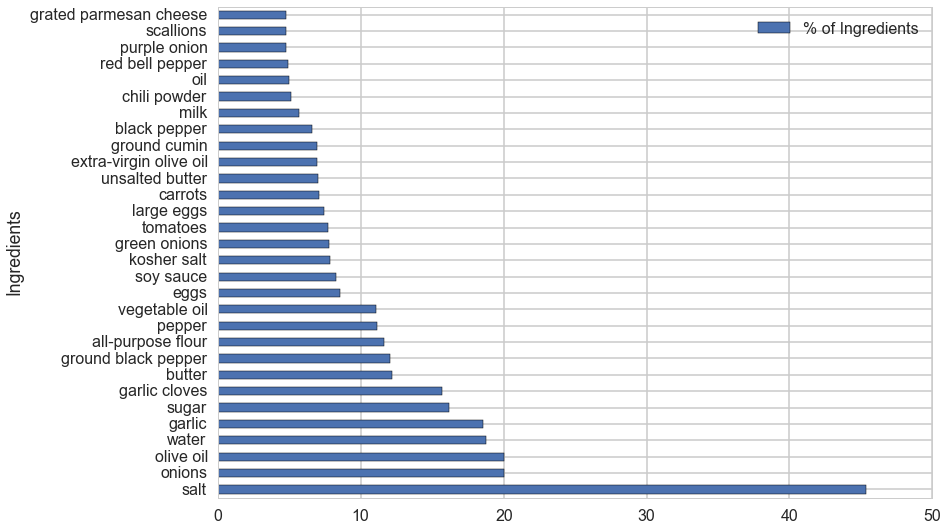

In [69]:
g2 = ingredientfrac.reset_index()
g2['Ingredients']=g2['index'].apply(lambda x: x.split('/')[-1].replace('_', ' ').replace('%26','&'))
del g2['index']
g2=g2.rename(columns={0:'% of Ingredients'})
g2.set_index('Ingredients')[:30].plot(kind="barh");

<img src="./images/Unknown-1.png">

# Yummly Integration (Version 0.5.0)

In [90]:
from yummly import Client

# default option values
TIMEOUT = 5.0
RETRIES = 0
YOUR_API_ID = "c077aa3e"
YOUR_API_KEY = "0390dca06586895a80f9d7f549030bda"
client = Client(api_id=YOUR_API_ID, api_key=YOUR_API_KEY, timeout=TIMEOUT, retries=RETRIES)

search = client.search('green eggs and ham')
match = search.matches[0]

recipe = client.recipe(match.id)
print recipe

Recipe({'totalTime': u'12 min', 'rating': 3, 'attribution': Attribution({'url': u'http://www.yummly.com/recipe/Green-Eggs-and-Ham-Cups-1035325', 'text': u'Green Eggs and Ham Cups recipes: information powered by Yummly', 'html': u"<a href='http://www.yummly.com/recipe/Green-Eggs-and-Ham-Cups-1035325'>Green Eggs and Ham Cups recipe</a> information powered by <img alt='Yummly' src='http://static.yummly.com/api-logo.png'/>", 'logo': u'http://static.yummly.com/api-logo.png'}), 'totalTimeInSeconds': 720, 'ingredientLines': [u'4 large eggs', u"4 slices of precooked bacon (like the kind you can get at Costco and just need to reheat. You can also use completely raw bacon, but you will have to precook it until it's pink and almost done before adding your raw egg in)", u'about 3 tsp of pesto per egg'], 'numberOfServings': 4, 'flavors': Flavors({'piquant': None, 'sour': None, 'salty': None, 'sweet': None, 'bitter': None, 'meaty': None}), 'source': RecipeSource({'sourceSiteUrl': u'http://kirbiecrav

#### Search for recipes meeting certain criteria and limit your results to a maximum

In [94]:
from yummly import Client

results = client.search('bacon', maxResults=1)

print('Total Matches:', results.totalMatchCount)
for match in results.matches:
    print('Recipe ID:', match.id)
    print('Recipe:', match.recipeName)
    print('Rating:', match.rating)
    print('Ingredients:')
    for ingred in match.ingredientLines:
        print(ingred)
    print('----------------------------------------------------')

('Total Matches:', 59542)
('Recipe ID:', u'Bacon-Bombs-1380396')
('Recipe:', u'Bacon Bombs')
('Rating:', 4)
----------------------------------------------------
('Recipe ID:', u'Cheesy-Slow-Cooker-Bacon-Ranch-Potatoes-1390921')
('Recipe:', u'Cheesy Slow Cooker Bacon Ranch Potatoes')
('Rating:', 4)
----------------------------------------------------
('Recipe ID:', u'Bacon-Brittle-1372153')
('Recipe:', u'Bacon Brittle')
('Rating:', 3)
----------------------------------------------------
('Recipe ID:', u'Turkey-Bacon-Crescents-1390761')
('Recipe:', u'Turkey Bacon Crescents')
('Rating:', 4)
----------------------------------------------------
('Recipe ID:', u'Bacon-Bombs-1381866')
('Recipe:', u'Bacon Bombs')
('Rating:', 4)
----------------------------------------------------
('Recipe ID:', u'Bacon-Cheddar-Hasselback-Potatoes-1390499')
('Recipe:', u'Bacon Cheddar Hasselback Potatoes')
('Rating:', 4)
----------------------------------------------------
('Recipe ID:', u'Bacon-Crack-791741')


#### Provide search parameters:

In [ ]:
params = {
    'q': 'pork chops',
    'start': 0,
    'maxResult': 40,
    'requirePicutres': False,
    'allowedIngredient[]': ['salt', 'pepper'],
    'excludedIngredient[]': ['cumin', 'paprika'],
    'maxTotalTimeInSeconds': 3600,
    'facetField[]': ['ingredient', 'diet'],
    'flavor.meaty.min': 0.5,
    'flavor.meaty.max': 1,
    'flavor.sweet.min': 0,
    'flavor.sweet.max': 0.5,
    'nutrition.FAT.min': 0,
    'nutrition.FAT.max': 15
}

results = client.search(**params, maxResults=1)

In [ ]:
# ingredients = nrjrregrege


In [ ]:
# Predict

In [ ]:
# Result